# Weighting methods, illustration

Data from an observational study of 996 patients receiving an initial Percutaneous Coronary Intervention (PCI) at Ohio Heart Health, Christ Hospital, Cincinnati in 1997 and followed for at least 6 months by the staff of the Lindner Center. The patients thought to be more severely diseased were assigned to treatment with abciximab (an expensive, high-molecular-weight IIb/IIIa cascade blocker); in fact, only 298 (29.9 percent) of patients received usual-care-alone with their initial PCI. Data was obtained from the R package `twang`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.weightstats import CompareMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import scipy.stats as sps

sns.set_context('poster')


Bad key "text.kerning_factor" on line 4 in
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


Let's have a look and check the ATE, and its significance

In [2]:
# read the data
pci = pd.read_csv('lindner.csv', sep='\t')

# make the outcome numeric
pci = pci.assign(sixMonthSurvive_num = pci.sixMonthSurvive.astype(int))

# look at the raw difference in means
raw_diff_means = pci[pci.abcix==1].sixMonthSurvive_num.mean() - pci[pci.abcix==0].sixMonthSurvive_num.mean()
print('the difference in means is', raw_diff_means)

the difference in means is 0.03457625814888177


In [3]:
pci.head()

,lifepres,cardbill,abcix,stent,height,female,diabetic,acutemi,ejecfrac,ves1proc,sixMonthSurvive,sixMonthSurvive_num
0,0.0,14301,1,0,163,1,1,0,56,1,False,0
1,11.6,3563,1,0,168,0,0,0,56,1,True,1
2,11.6,4694,1,0,188,0,0,0,50,1,True,1
3,11.6,7366,1,0,175,0,1,0,50,1,True,1
4,11.6,8247,1,0,168,1,0,0,55,1,True,1


In [36]:
CompareMeans.from_data(pci[pci.abcix==1].sixMonthSurvive_num.values,
                       pci[pci.abcix==0].sixMonthSurvive_num.values).summary()

                          Test for equality of means                          
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
subset #1      0.0346      0.011      3.146      0.002       0.013       0.056


In [5]:
# standardize our covariates just for comparison
variables_to_standardize = ['stent', 'height', 'female', 'diabetic',
                            'acutemi', 'ejecfrac', 'ves1proc']
std_cols = ['{}_std'.format(c) for c in variables_to_standardize]
scaler = StandardScaler(with_mean=False)
scaled_df = pd.DataFrame(scaler.fit_transform(pci[variables_to_standardize]),
                         columns=std_cols)
pci_std = pd.concat([pci, scaled_df], axis=1)
pci_std.shape

(996, 19)

In [6]:
# balance between treated and control
balance_table = pci_std.groupby('abcix')[std_cols].mean()
print(balance_table.to_latex(float_format="%.2f"))

\begin{tabular}{lrrrrrrr}
\toprule
{} &  stent\_std &  height\_std &  female\_std &  diabetic\_std &  acutemi\_std &  ejecfrac\_std &  ves1proc\_std \\
abcix &            &             &             &               &              &               &               \\
\midrule
0     &       1.24 &       16.09 &        0.81 &          0.64 &         0.17 &          5.02 &          1.83 \\
1     &       1.50 &       16.09 &        0.70 &          0.49 &         0.51 &          4.84 &          2.23 \\
\bottomrule
\end{tabular}



/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/utils/fixes.py:230: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


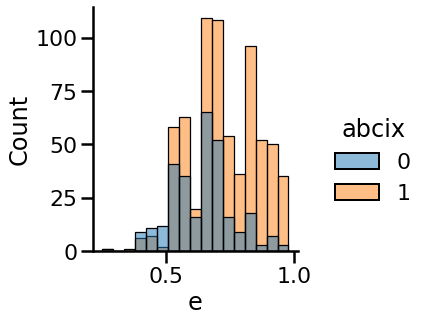

In [37]:
clf = LogisticRegression(random_state=10, penalty='none', solver='lbfgs').\
            fit(pci_std[variables_to_standardize], pci_std.abcix)
# Get the propensity scores for each observation
pci_std = pci_std.assign(e=clf.predict_proba(pci_std[variables_to_standardize])[:, 1])
# Histograms of the propensity scores in treatment and control
sns.displot(pci_std, x='e', hue='abcix', kind='hist')
plt.savefig('figures/pscore_hist.pdf', bbox_inches='tight')

In [8]:
pci_std = pci_std.assign(wt=np.nan)
pci_std.loc[pci_std.abcix==0, 'wt'] = 1 / (1-pci_std.loc[pci_std.abcix==0, 'e'])
pci_std.loc[pci_std.abcix==1, 'wt'] = 1 / (pci_std.loc[pci_std.abcix==1, 'e'])

obs_point_wtd = np.mean(pci_std.wt * pci_std.sixMonthSurvive_num * pci_std.abcix -
                    pci_std.wt * pci_std.sixMonthSurvive_num * (1-pci_std.abcix))
print(obs_point_wtd)

0.06739493654446274


Let's now use bootstrap to get a measure of uncertainty

In [42]:
rg = np.random.default_rng(240)
n_boot = 1000
ate_boot = np.empty(n_boot)
N = len(pci_std) # nb of units
#iterate
for i in range(n_boot):
    idx_boot = rg.choice(N, N, replace=True)
    pci_boot = pci_std.loc[idx_boot]
    # Fit the propensity score model on the bootstrapped data
    clf = LogisticRegression(random_state=10).\
            fit(pci_boot[variables_to_standardize], pci_boot.abcix)
    pci_boot = pci_boot.assign(e=clf.predict_proba(pci_boot[variables_to_standardize])[:, 1])
    pci_boot = pci_boot.assign(wt=np.nan)
    pci_boot.loc[pci_boot.abcix==0, 'wt'] = 1 / (1-pci_boot.loc[pci_boot.abcix==0, 'e'])
    pci_boot.loc[pci_boot.abcix==1, 'wt'] = 1 / (pci_boot.loc[pci_boot.abcix==1, 'e'])

    point_wtd = np.mean(pci_boot.wt * pci_boot.sixMonthSurvive_num * pci_boot.abcix -
                        pci_boot.wt * pci_boot.sixMonthSurvive_num * (1-pci_boot.abcix))
    ate_boot[i] = point_wtd

/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: 

/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: 

/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: 

/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: 

/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: 

/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: 

/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: 

/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: 

/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: 

/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: 

/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: 

/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: 

/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: 

/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: 

/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: 

/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: 

/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: 

/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: 

/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: 

/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: 

/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: 

/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: 

/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: 

/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: 

/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: 

In [43]:
print([obs_point_wtd - sps.norm.ppf(0.975) * np.std(ate_boot),
       obs_point_wtd + sps.norm.ppf(0.975) * np.std(ate_boot)])

[0.02010850600177788, 0.1146813670871476]


In [44]:
np.std(ate_boot)

0.024126173192810782

In [33]:
def weighted(x, cols, w="wt"):
    return pd.Series(np.average(x[cols], weights=x[w], axis=0), cols)
    
balance_table_weighted = pci_std.groupby('abcix').apply(weighted, std_cols)

print(balance_table_weighted.to_latex(float_format="%.2f"))


\begin{tabular}{lrrrrrrr}
\toprule
{} &  stent\_std &  height\_std &  female\_std &  diabetic\_std &  acutemi\_std &  ejecfrac\_std &  ves1proc\_std \\
abcix &            &             &             &               &              &               &               \\
\midrule
0     &       1.42 &       16.16 &        0.72 &          0.58 &         0.43 &          4.92 &          2.17 \\
1     &       1.42 &       16.08 &        0.71 &          0.54 &         0.41 &          4.89 &          2.10 \\
\bottomrule
\end{tabular}



In [31]:
pci_boot

['stent_std',
 'height_std',
 'female_std',
 'diabetic_std',
 'acutemi_std',
 'ejecfrac_std',
 'ves1proc_std']

In [41]:
pci_boot.e.min()

0.3069714076272262